In [ ]:
!git clone https://github.com/mln00b/eva6-assignments.git
%cd eva6-assignments/sess6
!pwd

Cloning into 'eva6-assignments'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 39 (delta 12), reused 33 (delta 10), pack-reused 0
Unpacking objects: 100% (39/39), done.
/content/eva6-assignments/sess6
/content/eva6-assignments/sess6


In [ ]:
import torch
import torch.optim as optim
from torchsummary import summary

%matplotlib inline
import matplotlib.pyplot as plt
import pickle

In [ ]:
from src.data import get_dataloaders
from src.model import MNISTNet
from src.train import train_epoch, get_optimizer
from src.test import test

In [ ]:
EPOCHS = 20

SEED = 42
use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
device

CUDA Available? True


device(type='cuda')

## Utils

In [ ]:
def plot_misclassified(data, title, r=5,c=4):
  fig, axs = plt.subplots(r,c,figsize=(15,10))
  fig.tight_layout()

  for i in range(r):
    for j in range(c):
      axs[i][j].axis('off')
      axs[i][j].set_title(f"Target: {str(data[(i*c)+j]['target'])}\nPred: {str(data[(i*c)+j]['pred'])}")
      axs[i][j].imshow(data[(i*c)+j]['data'])

def inverse_normalize(tensor, mean=(0.1307,), std=(0.3081,)):
  # Not mul by 255 here
  for t, m, s in zip(tensor, mean, std):
      t.mul_(s).add_(m)
  return tensor

def get_misclassified(model, title, n=20,r=5,c=4):
  model.eval()
  _, test_loader = get_dataloaders(val_batch_size=1)
  wrong = []
  with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).item()
        if not correct:
          wrong.append({
              "data": inverse_normalize(data).squeeze().cpu(),
              "target": target.item(),
              "pred": pred.item()
          })
  
  plot_misclassified(wrong[:n], title, r, c)

In [ ]:
def plot_single(title, train_losses, train_acc, test_losses, test_acc):
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  fig.suptitle(title)
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc[4000:])
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

def plot_multi(ls_title, ls_train_losses, ls_train_acc, ls_test_losses, ls_test_acc):
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  fig.suptitle(" | ".join(ls_title))

  for train_losses in ls_train_losses:
    axs[0, 0].plot(train_losses)
  axs[0, 0].legend(ls_title)
  axs[0, 0].set_title("Training Loss")
  
  for train_acc in ls_train_acc:
    axs[1, 0].plot(train_acc[4000:])
  axs[1, 0].legend(ls_title)
  axs[1, 0].set_title("Training Accuracy")
  
  for test_losses in ls_test_losses:
    axs[0, 1].plot(test_losses)
  axs[0, 1].legend(ls_title)
  axs[0, 1].set_title("Test Loss")
  
  for test_acc in ls_test_acc:
    axs[1, 1].plot(test_acc)
  axs[1, 1].legend(ls_title)
  axs[1, 1].set_title("Test Accuracy")

## Trainer

In [ ]:
def train_model(desc, bn=False, gn=False, ln=False, l1=False, l2=False):
  train_losses = []
  test_losses = []
  train_acc = []
  test_accs = []

  model =  MNISTNet(use_batchnorm=bn, use_groupnorm=gn, use_layernorm=ln).to(device)
  train_loader, test_loader = get_dataloaders()

  summary(model, input_size=(1, 28, 28))

  wd = 0
  lambda_l1 = None

  if l1: lambda_l1 = 0.01
  if l2: wd = 0.01

  optimizer = get_optimizer(model.parameters(), lr=0.01, momentum=0.9, weight_decay=wd) 

  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train_epoch_losses, train_epoch_acc = train_epoch(model, device, train_loader, optimizer, lambda_l1=lambda_l1)
      test_loss, test_acc = test(model, device, test_loader)
      train_losses.extend(train_epoch_losses)
      train_acc.extend(train_epoch_acc)
      test_losses.append(test_loss)
      test_accs.append(test_acc)

  torch.save(model.state_dict(), f"{desc}.pth")
  # pickle.dump(train_losses, open(f"{desc}_train_losses.p", "wb"))
  # pickle.dump(train_acc, open(f"{desc}_train_acc.p", "wb"))
  # pickle.dump(test_losses, open(f"{desc}_test_losses.p", "wb"))
  # pickle.dump(test_accs, open(f"{desc}_test_accs.p", "wb"))
  plot_single(desc, train_losses, train_acc, test_losses, test_accs)
  return model, train_losses, test_losses, train_acc, test_accs

## BatchNorm

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!
CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 16, 24, 24]           2,304
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
           Dropout-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           2,304
             ReLU-10           [-1, 16, 10, 10]               0
      BatchNorm2d-11           [-1, 16, 10, 10]              32
        MaxPool2d-12             [-1, 16, 5, 5]               0
          Dropout-13             [-1, 16, 5, 5]               0
           Conv2d-14             [-1, 1

Loss=0.1532103419303894 Batch_id=468 Accuracy=89.87: 100%|██████████| 469/469 [00:13<00:00, 34.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0683, Accuracy: 9784/10000 (97.84%)

EPOCH: 1


Loss=0.03685896098613739 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:14<00:00, 33.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9872/10000 (98.72%)

EPOCH: 2


Loss=0.0409432090818882 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9880/10000 (98.80%)

EPOCH: 3


Loss=0.1293679177761078 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.07499196380376816 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.0163698960095644 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:13<00:00, 33.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.08624318987131119 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 33.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9908/10000 (99.08%)

EPOCH: 7


Loss=0.025361761450767517 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 33.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.029291220009326935 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9896/10000 (98.96%)

EPOCH: 9


Loss=0.06175336241722107 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.006726250518113375 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.020467396825551987 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 33.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.18803541362285614 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.04850609600543976 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.033864837139844894 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 31.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9917/10000 (99.17%)

EPOCH: 15


Loss=0.01197002548724413 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Loss=0.06469011306762695 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 33.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9920/10000 (99.20%)

EPOCH: 17


Loss=0.02619873732328415 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.039945345371961594 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:14<00:00, 33.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.07436485588550568 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]



Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)



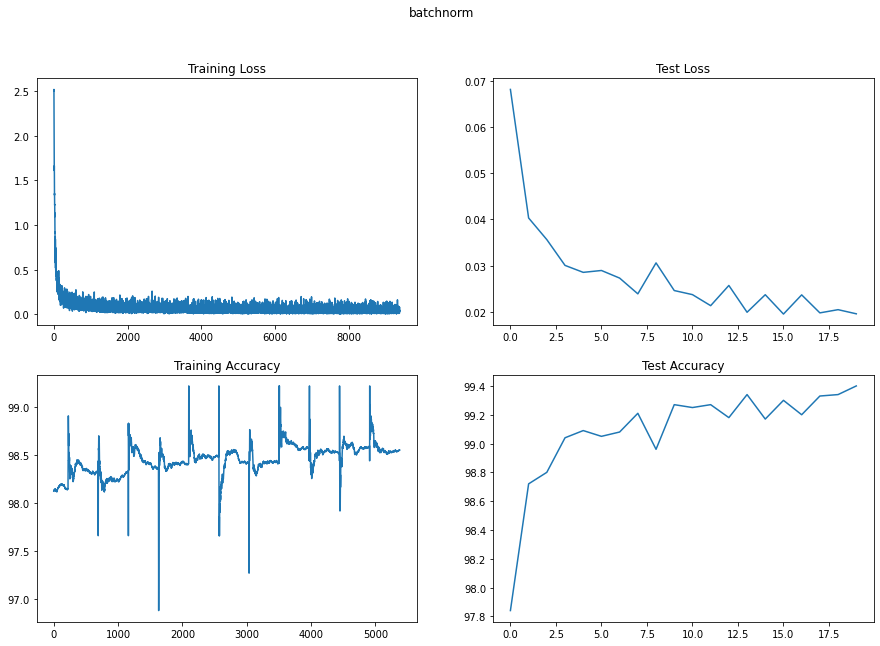

In [ ]:
model, batchnorm_train_losses, batchnorm_test_losses, batchnorm_train_acc, batchnorm_test_acc = train_model("batchnorm", bn=True)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


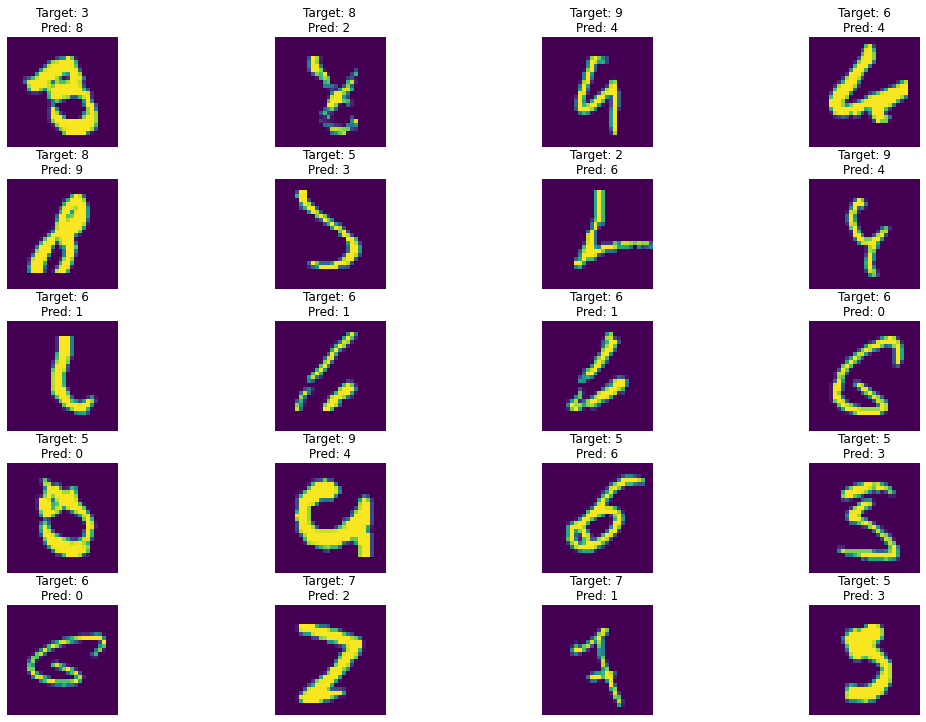

In [ ]:
get_misclassified(model, "batchnorm")
del model

## BatchNorm + L1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/469 [00:00<?, ?it/s]

CUDA Available? True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 16, 24, 24]           2,304
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
           Dropout-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           2,304
             ReLU-10           [-1, 16, 10, 10]               0
      BatchNorm2d-11           [-1, 16, 10, 10]              32
        MaxPool2d-12             [-1, 16, 5, 5]               0
          Dropout-13             [-1, 16, 5, 5]               0
           Conv2d-

Loss=1.8089892864227295 Batch_id=468 Accuracy=86.77: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5156, Accuracy: 8249/10000 (82.49%)

EPOCH: 1


Loss=1.2328330278396606 Batch_id=468 Accuracy=90.54: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3081, Accuracy: 9275/10000 (92.75%)

EPOCH: 2


Loss=1.0733213424682617 Batch_id=468 Accuracy=90.23: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3541, Accuracy: 8925/10000 (89.25%)

EPOCH: 3


Loss=1.1349427700042725 Batch_id=468 Accuracy=90.15: 100%|██████████| 469/469 [00:14<00:00, 33.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3373, Accuracy: 9059/10000 (90.59%)

EPOCH: 4


Loss=1.0544281005859375 Batch_id=468 Accuracy=90.34: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6659, Accuracy: 8008/10000 (80.08%)

EPOCH: 5


Loss=1.1762923002243042 Batch_id=468 Accuracy=90.39: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2041, Accuracy: 9422/10000 (94.22%)

EPOCH: 6


Loss=1.0688996315002441 Batch_id=468 Accuracy=90.21: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2702, Accuracy: 9230/10000 (92.30%)

EPOCH: 7


Loss=1.1359091997146606 Batch_id=468 Accuracy=90.32: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4178, Accuracy: 8792/10000 (87.92%)

EPOCH: 8


Loss=0.9596850872039795 Batch_id=468 Accuracy=90.14: 100%|██████████| 469/469 [00:14<00:00, 32.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6138, Accuracy: 8120/10000 (81.20%)

EPOCH: 9


Loss=1.0788915157318115 Batch_id=468 Accuracy=90.25: 100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3582, Accuracy: 8940/10000 (89.40%)

EPOCH: 10


Loss=1.0327653884887695 Batch_id=468 Accuracy=90.05: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2089, Accuracy: 9396/10000 (93.96%)

EPOCH: 11


Loss=1.062774896621704 Batch_id=468 Accuracy=90.22: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1796, Accuracy: 9541/10000 (95.41%)

EPOCH: 12


Loss=1.160096526145935 Batch_id=468 Accuracy=90.02: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2458, Accuracy: 9252/10000 (92.52%)

EPOCH: 13


Loss=1.1971116065979004 Batch_id=468 Accuracy=90.54: 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2813, Accuracy: 9257/10000 (92.57%)

EPOCH: 14


Loss=1.166803240776062 Batch_id=468 Accuracy=90.31: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2083, Accuracy: 9498/10000 (94.98%)

EPOCH: 15


Loss=0.9585944414138794 Batch_id=468 Accuracy=90.25: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2913, Accuracy: 9349/10000 (93.49%)

EPOCH: 16


Loss=1.2063419818878174 Batch_id=468 Accuracy=90.42: 100%|██████████| 469/469 [00:14<00:00, 32.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.8363, Accuracy: 7148/10000 (71.48%)

EPOCH: 17


Loss=1.1743271350860596 Batch_id=468 Accuracy=90.29: 100%|██████████| 469/469 [00:14<00:00, 32.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5686, Accuracy: 8238/10000 (82.38%)

EPOCH: 18


Loss=1.1190733909606934 Batch_id=468 Accuracy=90.29: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4766, Accuracy: 8556/10000 (85.56%)

EPOCH: 19


Loss=1.1883890628814697 Batch_id=468 Accuracy=90.21: 100%|██████████| 469/469 [00:14<00:00, 32.59it/s]



Test set: Average loss: 0.2012, Accuracy: 9413/10000 (94.13%)



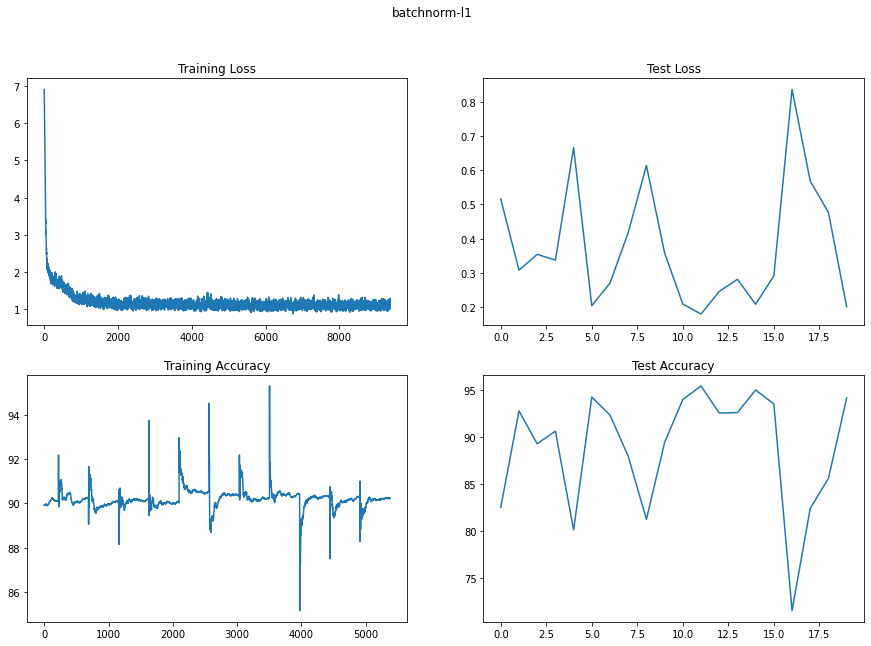

In [ ]:
model, batchnorm_l1_train_losses, batchnorm_l1_test_losses, batchnorm_l1_train_acc, batchnorm_l1_test_acc = train_model("batchnorm-l1", bn=True,l1=True)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


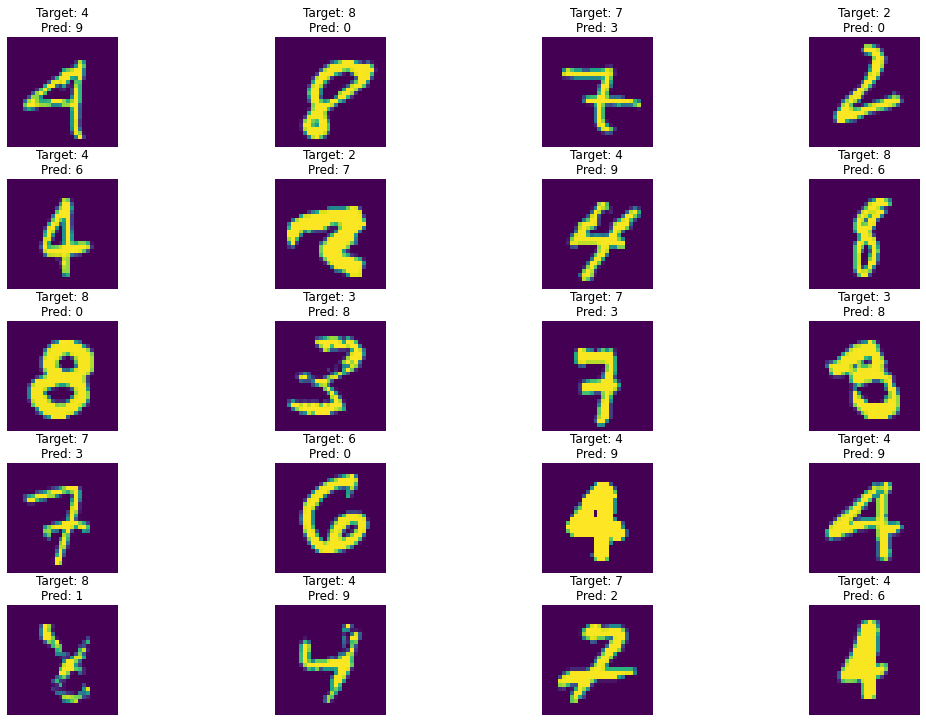

In [ ]:
get_misclassified(model, "batchnorm-L1")
del model

##BatchNorm + L2

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/469 [00:00<?, ?it/s]

CUDA Available? True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 16, 24, 24]           2,304
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
           Dropout-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           2,304
             ReLU-10           [-1, 16, 10, 10]               0
      BatchNorm2d-11           [-1, 16, 10, 10]              32
        MaxPool2d-12             [-1, 16, 5, 5]               0
          Dropout-13             [-1, 16, 5, 5]               0
           Conv2d-

Loss=0.1461896002292633 Batch_id=468 Accuracy=90.17: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0710, Accuracy: 9819/10000 (98.19%)

EPOCH: 1


Loss=0.1178508996963501 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9841/10000 (98.41%)

EPOCH: 2


Loss=0.09631866216659546 Batch_id=468 Accuracy=97.10: 100%|██████████| 469/469 [00:13<00:00, 33.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0821, Accuracy: 9766/10000 (97.66%)

EPOCH: 3


Loss=0.11373475939035416 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0628, Accuracy: 9847/10000 (98.47%)

EPOCH: 4


Loss=0.06959724426269531 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:13<00:00, 33.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9858/10000 (98.58%)

EPOCH: 5


Loss=0.041059669107198715 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0634, Accuracy: 9805/10000 (98.05%)

EPOCH: 6


Loss=0.08295504748821259 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9857/10000 (98.57%)

EPOCH: 7


Loss=0.0955636203289032 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9864/10000 (98.64%)

EPOCH: 8


Loss=0.07221323251724243 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:13<00:00, 34.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9875/10000 (98.75%)

EPOCH: 9


Loss=0.13241147994995117 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0589, Accuracy: 9850/10000 (98.50%)

EPOCH: 10


Loss=0.05697081610560417 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9888/10000 (98.88%)

EPOCH: 11


Loss=0.061753664165735245 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9879/10000 (98.79%)

EPOCH: 12


Loss=0.15288285911083221 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0738, Accuracy: 9784/10000 (97.84%)

EPOCH: 13


Loss=0.13488806784152985 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 9860/10000 (98.60%)

EPOCH: 14


Loss=0.04928189888596535 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:14<00:00, 33.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9892/10000 (98.92%)

EPOCH: 15


Loss=0.04072149097919464 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9847/10000 (98.47%)

EPOCH: 16


Loss=0.18426549434661865 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9841/10000 (98.41%)

EPOCH: 17


Loss=0.09738137573003769 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0943, Accuracy: 9732/10000 (97.32%)

EPOCH: 18


Loss=0.12185963243246078 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9877/10000 (98.77%)

EPOCH: 19


Loss=0.11117923259735107 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]



Test set: Average loss: 0.0506, Accuracy: 9871/10000 (98.71%)



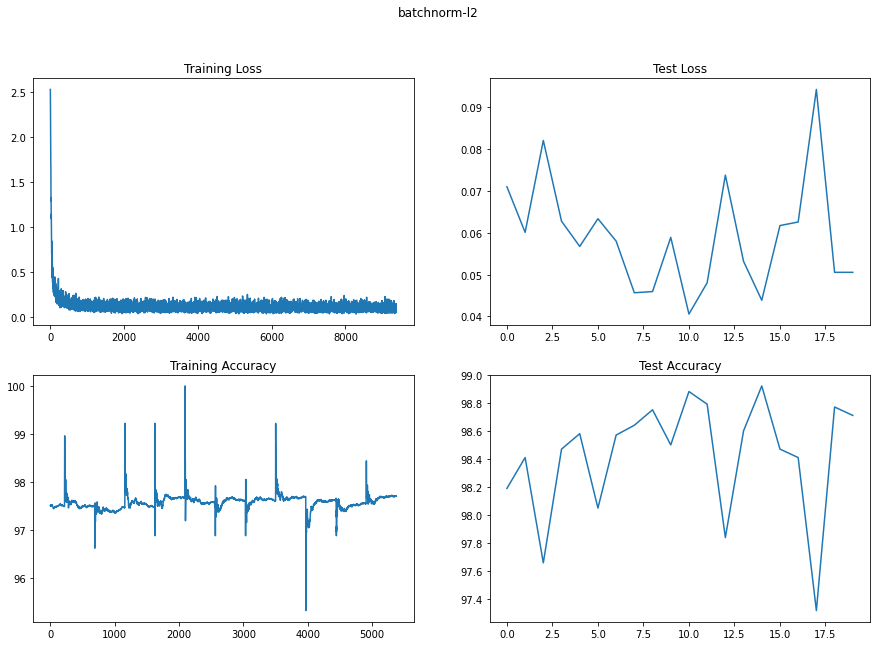

In [ ]:
model, batchnorm_l2_train_losses, batchnorm_l2_test_losses, batchnorm_l2_train_acc, batchnorm_l2_test_acc = train_model("batchnorm-l2", bn=True,l2=True)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


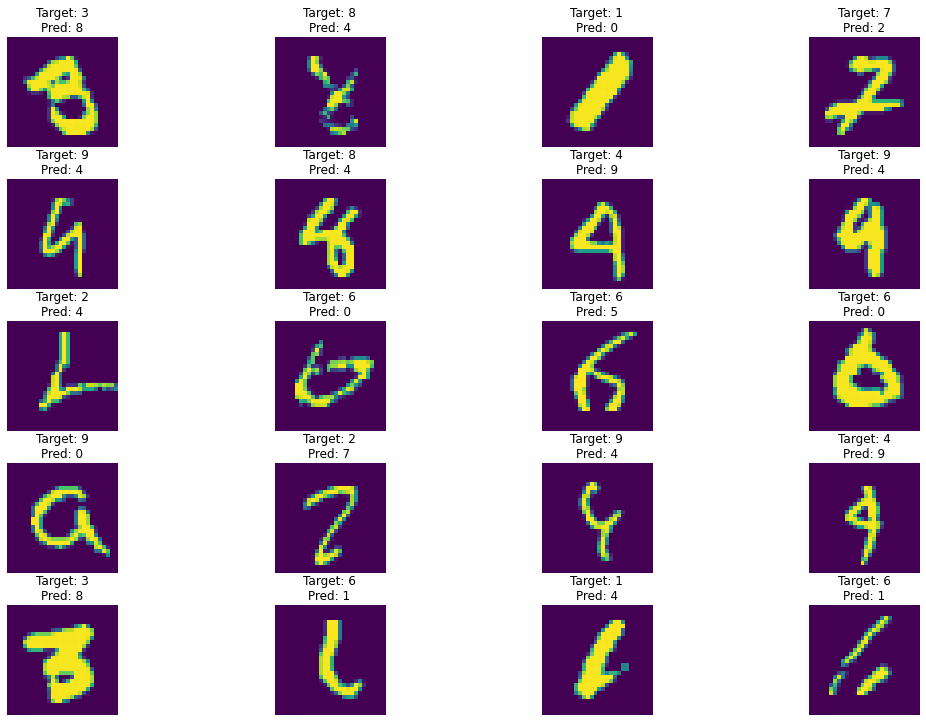

In [ ]:
get_misclassified(model, "batchnorm-L2")
del model

## BatchNorm + L1 + L2

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/469 [00:00<?, ?it/s]

CUDA Available? True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 16, 24, 24]           2,304
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
           Dropout-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           2,304
             ReLU-10           [-1, 16, 10, 10]               0
      BatchNorm2d-11           [-1, 16, 10, 10]              32
        MaxPool2d-12             [-1, 16, 5, 5]               0
          Dropout-13             [-1, 16, 5, 5]               0
           Conv2d-

Loss=1.502000331878662 Batch_id=468 Accuracy=86.36: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7185, Accuracy: 7619/10000 (76.19%)

EPOCH: 1


Loss=1.1314597129821777 Batch_id=468 Accuracy=90.28: 100%|██████████| 469/469 [00:14<00:00, 32.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3604, Accuracy: 8908/10000 (89.08%)

EPOCH: 2


Loss=1.0842145681381226 Batch_id=468 Accuracy=89.70: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6586, Accuracy: 8107/10000 (81.07%)

EPOCH: 3


Loss=1.1848220825195312 Batch_id=468 Accuracy=89.77: 100%|██████████| 469/469 [00:14<00:00, 32.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3803, Accuracy: 8739/10000 (87.39%)

EPOCH: 4


Loss=1.06785249710083 Batch_id=468 Accuracy=89.69: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2862, Accuracy: 9392/10000 (93.92%)

EPOCH: 5


Loss=1.211805820465088 Batch_id=468 Accuracy=89.85: 100%|██████████| 469/469 [00:14<00:00, 32.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2445, Accuracy: 9335/10000 (93.35%)

EPOCH: 6


Loss=1.0872591733932495 Batch_id=468 Accuracy=89.82: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.8431, Accuracy: 7364/10000 (73.64%)

EPOCH: 7


Loss=1.1417553424835205 Batch_id=468 Accuracy=90.03: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7995, Accuracy: 7271/10000 (72.71%)

EPOCH: 8


Loss=0.9768239855766296 Batch_id=468 Accuracy=90.02: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3202, Accuracy: 9224/10000 (92.24%)

EPOCH: 9


Loss=1.2041983604431152 Batch_id=468 Accuracy=90.05: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4409, Accuracy: 8683/10000 (86.83%)

EPOCH: 10


Loss=1.0654945373535156 Batch_id=468 Accuracy=89.89: 100%|██████████| 469/469 [00:14<00:00, 32.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1953, Accuracy: 9478/10000 (94.78%)

EPOCH: 11


Loss=1.0384007692337036 Batch_id=468 Accuracy=89.90: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2848, Accuracy: 9246/10000 (92.46%)

EPOCH: 12


Loss=1.2951140403747559 Batch_id=468 Accuracy=89.87: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4761, Accuracy: 8733/10000 (87.33%)

EPOCH: 13


Loss=1.2736456394195557 Batch_id=468 Accuracy=90.08: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3177, Accuracy: 9214/10000 (92.14%)

EPOCH: 14


Loss=1.0935996770858765 Batch_id=468 Accuracy=89.91: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5253, Accuracy: 8334/10000 (83.34%)

EPOCH: 15


Loss=1.009805679321289 Batch_id=468 Accuracy=89.95: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2290, Accuracy: 9418/10000 (94.18%)

EPOCH: 16


Loss=1.281907081604004 Batch_id=468 Accuracy=90.18: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4977, Accuracy: 8441/10000 (84.41%)

EPOCH: 17


Loss=1.0594950914382935 Batch_id=468 Accuracy=89.86: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1943, Accuracy: 9564/10000 (95.64%)

EPOCH: 18


Loss=1.0701522827148438 Batch_id=468 Accuracy=89.87: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2131, Accuracy: 9418/10000 (94.18%)

EPOCH: 19


Loss=1.1579025983810425 Batch_id=468 Accuracy=90.21: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]



Test set: Average loss: 0.6025, Accuracy: 8175/10000 (81.75%)



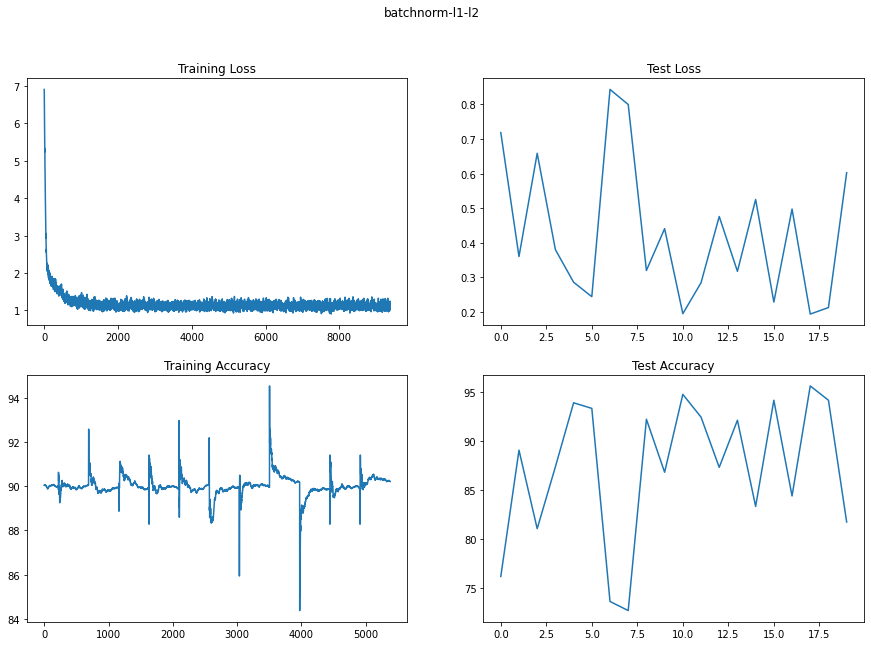

In [ ]:
model, batchnorm_l1_l2_train_losses, batchnorm_l1_l2_test_losses, batchnorm_l1_l2_train_acc, batchnorm_l1_l2_test_acc = train_model("batchnorm-l1-l2", bn=True,l1=True, l2=True)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


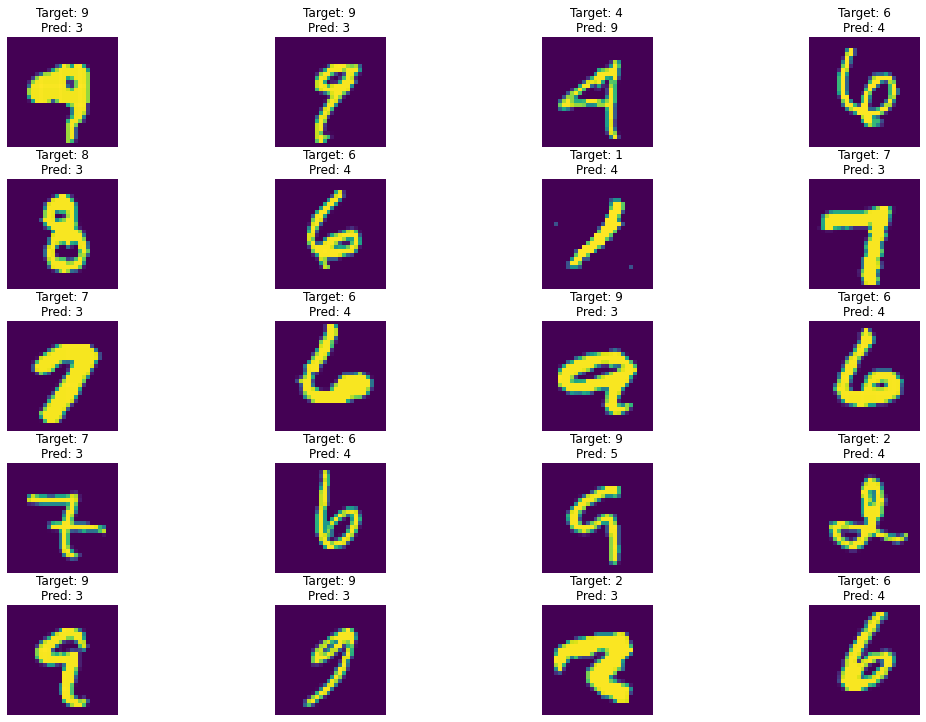

In [ ]:
get_misclassified(model, "batchnorm-L1-L2")
del model

## LayerNorm

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/469 [00:00<?, ?it/s]

CUDA Available? True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         LayerNorm-3           [-1, 16, 26, 26]          21,632
            Conv2d-4           [-1, 16, 24, 24]           2,304
              ReLU-5           [-1, 16, 24, 24]               0
         LayerNorm-6           [-1, 16, 24, 24]          18,432
         MaxPool2d-7           [-1, 16, 12, 12]               0
           Dropout-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           2,304
             ReLU-10           [-1, 16, 10, 10]               0
        LayerNorm-11           [-1, 16, 10, 10]           3,200
        MaxPool2d-12             [-1, 16, 5, 5]               0
          Dropout-13             [-1, 16, 5, 5]               0
           Conv2d-

Loss=0.10080822557210922 Batch_id=468 Accuracy=88.53: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9845/10000 (98.45%)

EPOCH: 1


Loss=0.029793433845043182 Batch_id=468 Accuracy=96.53: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9872/10000 (98.72%)

EPOCH: 2


Loss=0.0657927468419075 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9867/10000 (98.67%)

EPOCH: 3


Loss=0.1479163020849228 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.06849326938390732 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:13<00:00, 33.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.0411229208111763 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:14<00:00, 33.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9927/10000 (99.27%)

EPOCH: 6


Loss=0.0859212577342987 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.06318317353725433 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.02341495454311371 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.0754784420132637 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.006487660575658083 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.0364716537296772 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:13<00:00, 33.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.27026835083961487 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 33.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.05977968871593475 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 33.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.018743718042969704 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


Loss=0.020031947642564774 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.11794236302375793 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.06307219713926315 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.08470184355974197 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:14<00:00, 33.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


Loss=0.05173824355006218 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]



Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)



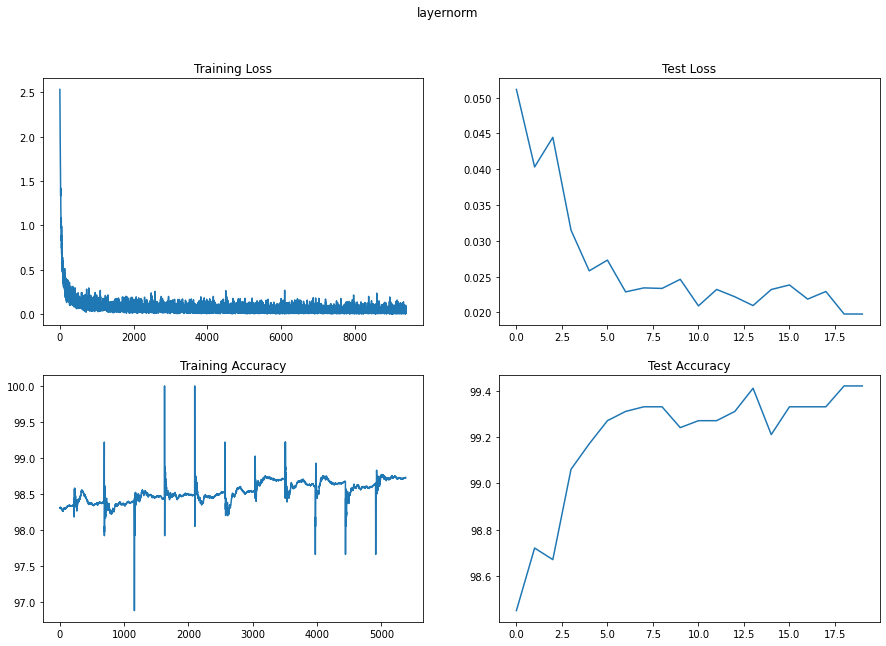

In [ ]:
model, layernorm_train_losses, layernorm_test_losses, layernorm_train_acc, layernorm_test_acc = train_model("layernorm", ln=True)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


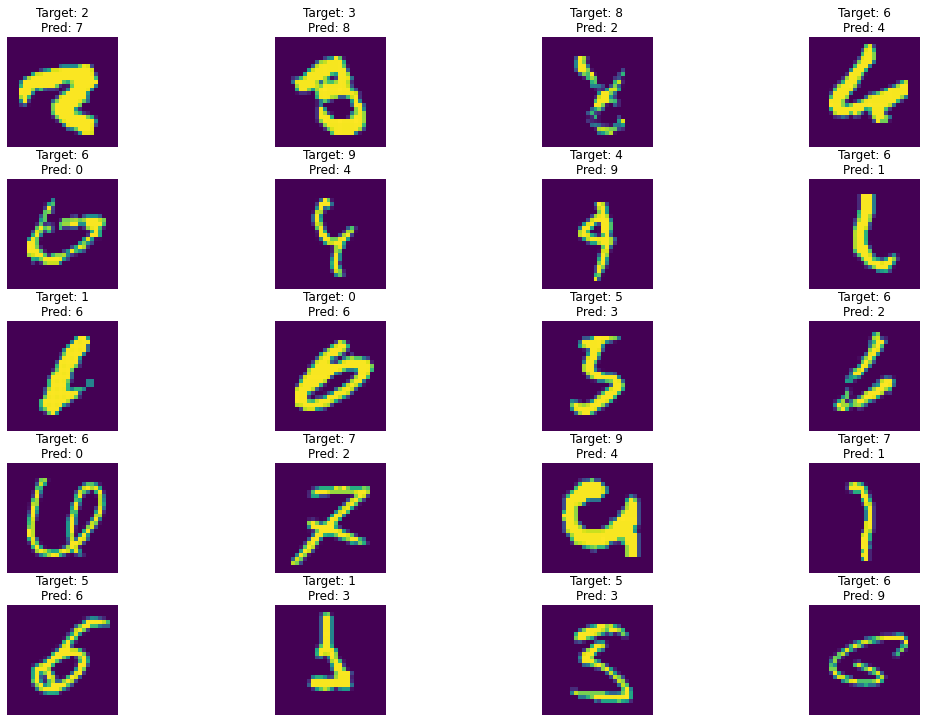

In [ ]:
get_misclassified(model, "layernorm")
del model

## LayerNorm + L1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/469 [00:00<?, ?it/s]

CUDA Available? True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         LayerNorm-3           [-1, 16, 26, 26]          21,632
            Conv2d-4           [-1, 16, 24, 24]           2,304
              ReLU-5           [-1, 16, 24, 24]               0
         LayerNorm-6           [-1, 16, 24, 24]          18,432
         MaxPool2d-7           [-1, 16, 12, 12]               0
           Dropout-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           2,304
             ReLU-10           [-1, 16, 10, 10]               0
        LayerNorm-11           [-1, 16, 10, 10]           3,200
        MaxPool2d-12             [-1, 16, 5, 5]               0
          Dropout-13             [-1, 16, 5, 5]               0
           Conv2d-

Loss=119.11121368408203 Batch_id=468 Accuracy=82.10: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2399, Accuracy: 9375/10000 (93.75%)

EPOCH: 1


Loss=17.127737045288086 Batch_id=468 Accuracy=87.63: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1787, Accuracy: 9550/10000 (95.50%)

EPOCH: 2


Loss=2.0483548641204834 Batch_id=468 Accuracy=76.36: 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3552, Accuracy: 9036/10000 (90.36%)

EPOCH: 3


Loss=2.124915838241577 Batch_id=468 Accuracy=74.28: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4175, Accuracy: 8911/10000 (89.11%)

EPOCH: 4


Loss=1.8796932697296143 Batch_id=468 Accuracy=74.42: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3922, Accuracy: 9025/10000 (90.25%)

EPOCH: 5


Loss=1.8797835111618042 Batch_id=468 Accuracy=74.07: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4040, Accuracy: 8915/10000 (89.15%)

EPOCH: 6


Loss=2.1701772212982178 Batch_id=468 Accuracy=73.59: 100%|██████████| 469/469 [00:14<00:00, 32.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4670, Accuracy: 8693/10000 (86.93%)

EPOCH: 7


Loss=1.8210103511810303 Batch_id=468 Accuracy=73.17: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4434, Accuracy: 8716/10000 (87.16%)

EPOCH: 8


Loss=1.863792896270752 Batch_id=468 Accuracy=73.34: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4682, Accuracy: 8879/10000 (88.79%)

EPOCH: 9


Loss=2.047816038131714 Batch_id=468 Accuracy=73.20: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4484, Accuracy: 8851/10000 (88.51%)

EPOCH: 10


Loss=1.8347971439361572 Batch_id=468 Accuracy=72.89: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4412, Accuracy: 8894/10000 (88.94%)

EPOCH: 11


Loss=1.941192626953125 Batch_id=468 Accuracy=72.80: 100%|██████████| 469/469 [00:14<00:00, 32.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4617, Accuracy: 8801/10000 (88.01%)

EPOCH: 12


Loss=1.9627606868743896 Batch_id=468 Accuracy=72.45: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4522, Accuracy: 8728/10000 (87.28%)

EPOCH: 13


Loss=1.8766586780548096 Batch_id=468 Accuracy=72.52: 100%|██████████| 469/469 [00:14<00:00, 32.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4248, Accuracy: 8883/10000 (88.83%)

EPOCH: 14


Loss=2.027364730834961 Batch_id=468 Accuracy=73.07: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4781, Accuracy: 8703/10000 (87.03%)

EPOCH: 15


Loss=1.6837897300720215 Batch_id=468 Accuracy=72.78: 100%|██████████| 469/469 [00:14<00:00, 32.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4643, Accuracy: 8767/10000 (87.67%)

EPOCH: 16


Loss=1.8967947959899902 Batch_id=468 Accuracy=72.33: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4561, Accuracy: 8763/10000 (87.63%)

EPOCH: 17


Loss=1.9293932914733887 Batch_id=468 Accuracy=72.35: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5646, Accuracy: 8270/10000 (82.70%)

EPOCH: 18


Loss=1.9755911827087402 Batch_id=468 Accuracy=72.12: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4771, Accuracy: 8710/10000 (87.10%)

EPOCH: 19


Loss=2.1094253063201904 Batch_id=468 Accuracy=71.92: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]



Test set: Average loss: 0.4664, Accuracy: 8734/10000 (87.34%)



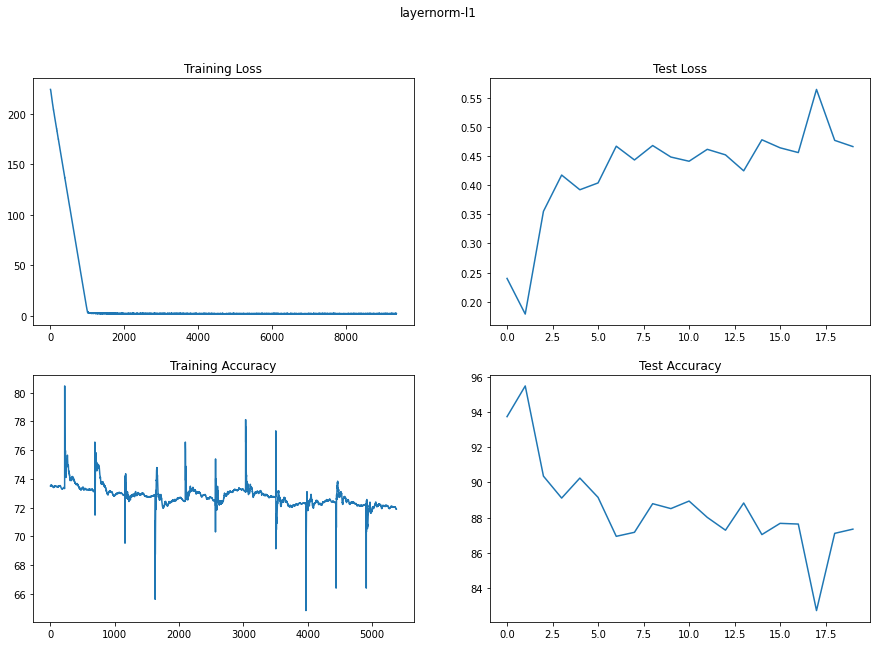

In [ ]:
model, layernorm_l1_train_losses, layernorm_l1_test_losses, layernorm_l1_train_acc, layernorm_l1_test_acc = train_model("layernorm-l1", ln=True,l1=True)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


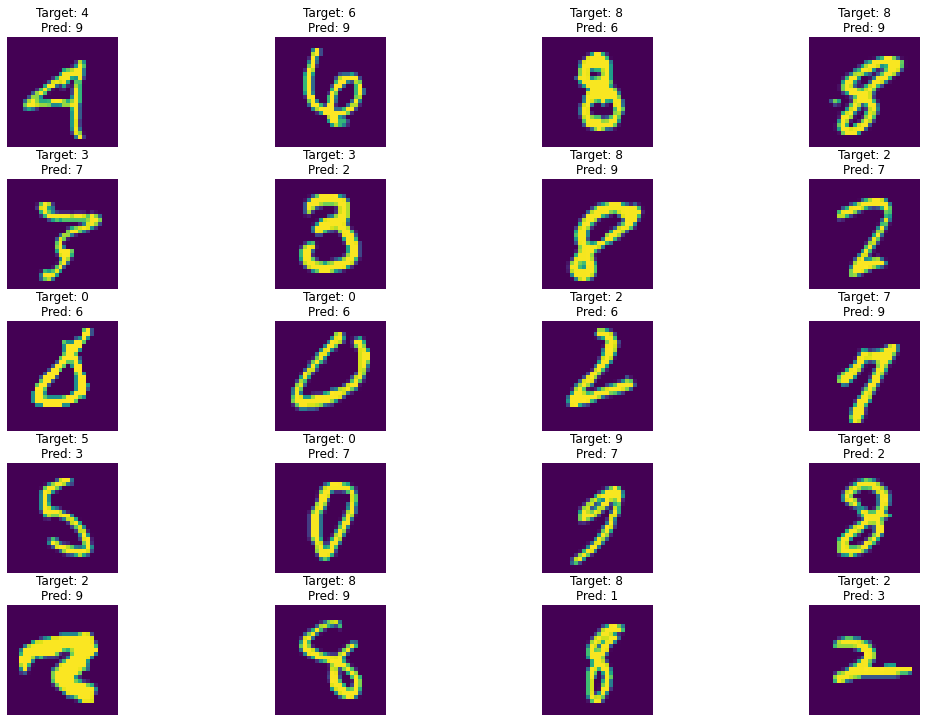

In [ ]:
get_misclassified(model, "layernorm-L1")
del model

## LayerNorm + L2

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/469 [00:00<?, ?it/s]

CUDA Available? True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         LayerNorm-3           [-1, 16, 26, 26]          21,632
            Conv2d-4           [-1, 16, 24, 24]           2,304
              ReLU-5           [-1, 16, 24, 24]               0
         LayerNorm-6           [-1, 16, 24, 24]          18,432
         MaxPool2d-7           [-1, 16, 12, 12]               0
           Dropout-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           2,304
             ReLU-10           [-1, 16, 10, 10]               0
        LayerNorm-11           [-1, 16, 10, 10]           3,200
        MaxPool2d-12             [-1, 16, 5, 5]               0
          Dropout-13             [-1, 16, 5, 5]               0
           Conv2d-

Loss=0.12216367572546005 Batch_id=468 Accuracy=88.59: 100%|██████████| 469/469 [00:13<00:00, 34.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0804, Accuracy: 9820/10000 (98.20%)

EPOCH: 1


Loss=0.09690631181001663 Batch_id=468 Accuracy=96.30: 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0702, Accuracy: 9835/10000 (98.35%)

EPOCH: 2


Loss=0.10647961497306824 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:13<00:00, 33.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9867/10000 (98.67%)

EPOCH: 3


Loss=0.14051254093647003 Batch_id=468 Accuracy=96.73: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0658, Accuracy: 9849/10000 (98.49%)

EPOCH: 4


Loss=0.09182151407003403 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.05703129991889 Batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9839/10000 (98.39%)

EPOCH: 6


Loss=0.10729271173477173 Batch_id=468 Accuracy=96.27: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0665, Accuracy: 9841/10000 (98.41%)

EPOCH: 7


Loss=0.12867915630340576 Batch_id=468 Accuracy=95.64: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0834, Accuracy: 9769/10000 (97.69%)

EPOCH: 8


Loss=0.10815363377332687 Batch_id=468 Accuracy=95.33: 100%|██████████| 469/469 [00:14<00:00, 33.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0816, Accuracy: 9787/10000 (97.87%)

EPOCH: 9


Loss=0.26365217566490173 Batch_id=468 Accuracy=95.38: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0742, Accuracy: 9810/10000 (98.10%)

EPOCH: 10


Loss=0.12001980096101761 Batch_id=468 Accuracy=95.25: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0885, Accuracy: 9775/10000 (97.75%)

EPOCH: 11


Loss=0.14925077557563782 Batch_id=468 Accuracy=95.17: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0776, Accuracy: 9789/10000 (97.89%)

EPOCH: 12


Loss=0.19182412326335907 Batch_id=468 Accuracy=95.03: 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0872, Accuracy: 9762/10000 (97.62%)

EPOCH: 13


Loss=0.21381475031375885 Batch_id=468 Accuracy=95.25: 100%|██████████| 469/469 [00:13<00:00, 33.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0650, Accuracy: 9823/10000 (98.23%)

EPOCH: 14


Loss=0.12714208662509918 Batch_id=468 Accuracy=95.21: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0706, Accuracy: 9811/10000 (98.11%)

EPOCH: 15


Loss=0.09374301880598068 Batch_id=468 Accuracy=95.28: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0702, Accuracy: 9818/10000 (98.18%)

EPOCH: 16


Loss=0.2330736517906189 Batch_id=468 Accuracy=95.31: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9815/10000 (98.15%)

EPOCH: 17


Loss=0.20023177564144135 Batch_id=468 Accuracy=95.08: 100%|██████████| 469/469 [00:14<00:00, 31.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0786, Accuracy: 9787/10000 (97.87%)

EPOCH: 18


Loss=0.2247752696275711 Batch_id=468 Accuracy=95.16: 100%|██████████| 469/469 [00:15<00:00, 30.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0888, Accuracy: 9753/10000 (97.53%)

EPOCH: 19


Loss=0.3014403283596039 Batch_id=468 Accuracy=95.30: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]



Test set: Average loss: 0.0826, Accuracy: 9779/10000 (97.79%)



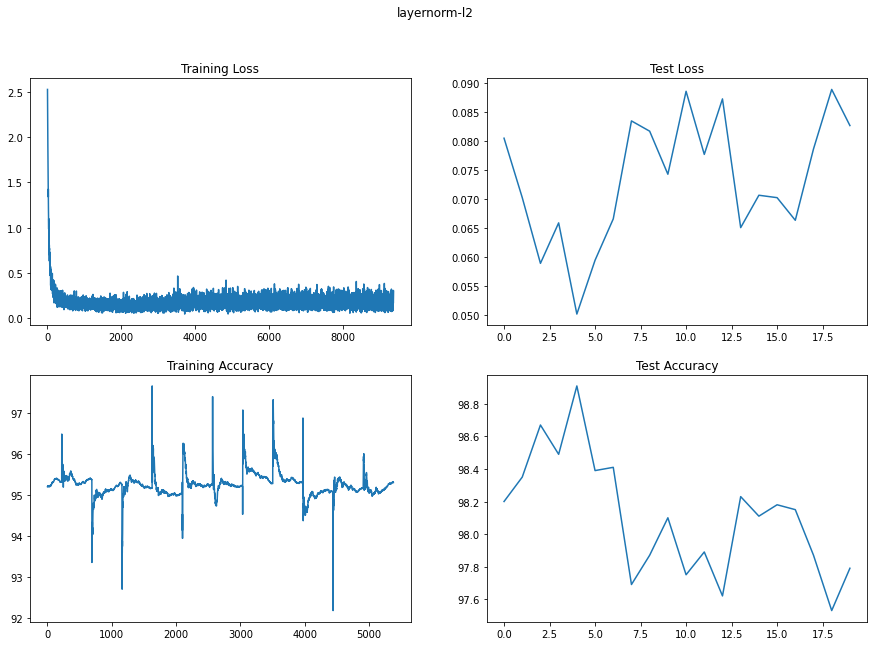

In [ ]:
model, layernorm_l2_train_losses, layernorm_l2_test_losses, layernorm_l2_train_acc, layernorm_l2_test_acc = train_model("layernorm-l2", ln=True,l2=True)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


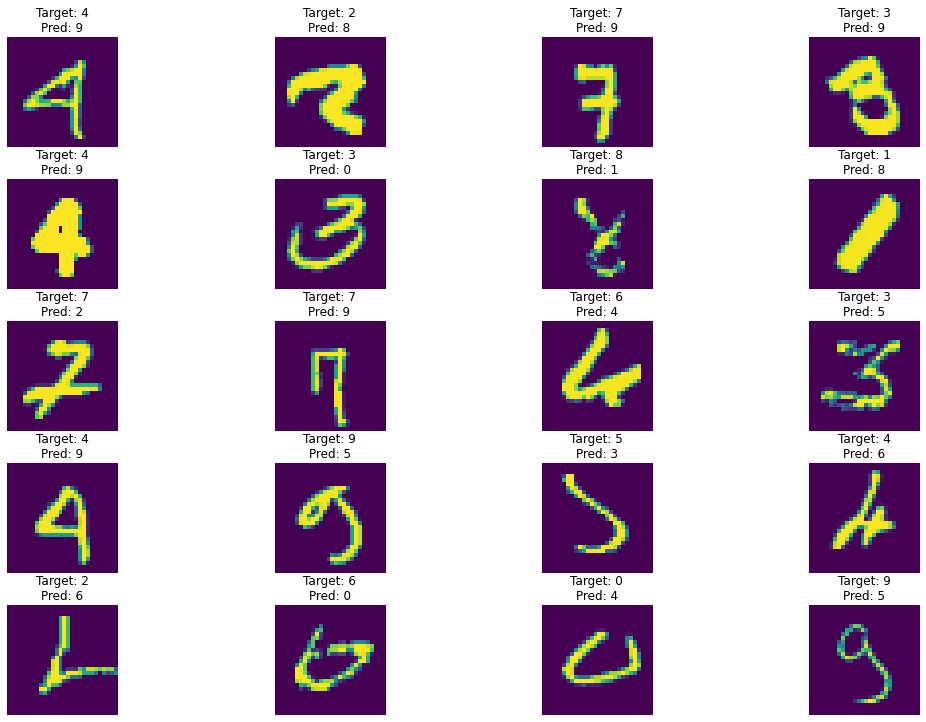

In [ ]:
get_misclassified(model, "layernorm-L2")
del model

## GroupNorm

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/469 [00:00<?, ?it/s]

CUDA Available? True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         GroupNorm-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 16, 24, 24]           2,304
              ReLU-5           [-1, 16, 24, 24]               0
         GroupNorm-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
           Dropout-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           2,304
             ReLU-10           [-1, 16, 10, 10]               0
        GroupNorm-11           [-1, 16, 10, 10]              32
        MaxPool2d-12             [-1, 16, 5, 5]               0
          Dropout-13             [-1, 16, 5, 5]               0
           Conv2d-

Loss=0.11499971151351929 Batch_id=468 Accuracy=88.61: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9834/10000 (98.34%)

EPOCH: 1


Loss=0.03142458200454712 Batch_id=468 Accuracy=96.51: 100%|██████████| 469/469 [00:13<00:00, 33.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9848/10000 (98.48%)

EPOCH: 2


Loss=0.06766411662101746 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.07766552269458771 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:13<00:00, 33.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.05917974188923836 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.007728140335530043 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.025964872911572456 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:13<00:00, 33.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.044960588216781616 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:14<00:00, 33.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.04453263059258461 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.07359152287244797 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.008257881738245487 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.028438089415431023 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.18739473819732666 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9910/10000 (99.10%)

EPOCH: 13


Loss=0.058783795684576035 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.04479263350367546 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9920/10000 (99.20%)

EPOCH: 15


Loss=0.009479138068854809 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99.13%)

EPOCH: 16


Loss=0.14945797622203827 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 33.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9924/10000 (99.24%)

EPOCH: 17


Loss=0.018338853493332863 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9923/10000 (99.23%)

EPOCH: 18


Loss=0.09983650594949722 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9921/10000 (99.21%)

EPOCH: 19


Loss=0.09755615144968033 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 32.57it/s]



Test set: Average loss: 0.0225, Accuracy: 9937/10000 (99.37%)



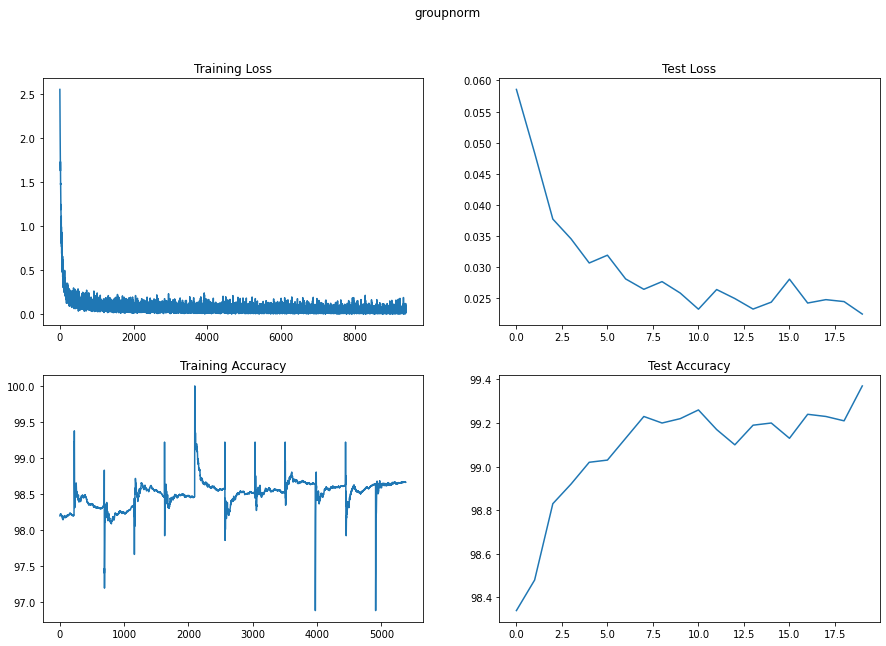

In [ ]:
model, groupnorm_train_losses, groupnorm_test_losses, groupnorm_train_acc, groupnorm_test_acc = train_model("groupnorm", gn=True)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


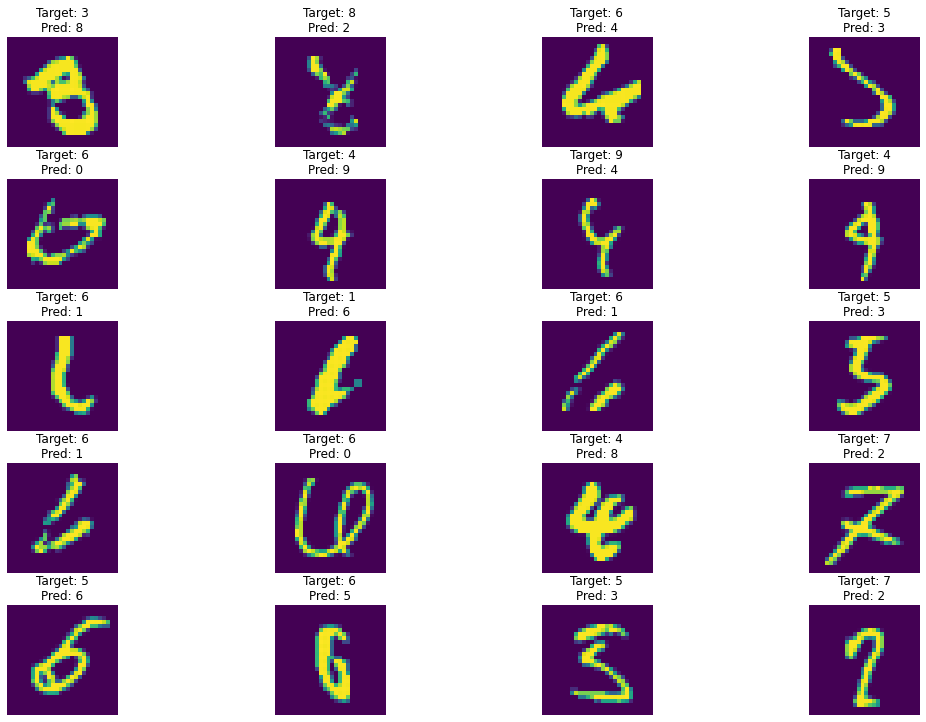

In [ ]:
get_misclassified(model, "groupnorm")
del model

## GroupNorm + L1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/469 [00:00<?, ?it/s]

CUDA Available? True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         GroupNorm-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 16, 24, 24]           2,304
              ReLU-5           [-1, 16, 24, 24]               0
         GroupNorm-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
           Dropout-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           2,304
             ReLU-10           [-1, 16, 10, 10]               0
        GroupNorm-11           [-1, 16, 10, 10]              32
        MaxPool2d-12             [-1, 16, 5, 5]               0
          Dropout-13             [-1, 16, 5, 5]               0
           Conv2d-

Loss=1.4517722129821777 Batch_id=468 Accuracy=82.40: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3766, Accuracy: 8922/10000 (89.22%)

EPOCH: 1


Loss=1.1628062725067139 Batch_id=468 Accuracy=87.23: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1687, Accuracy: 9542/10000 (95.42%)

EPOCH: 2


Loss=1.2337843179702759 Batch_id=468 Accuracy=87.18: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1706, Accuracy: 9529/10000 (95.29%)

EPOCH: 3


Loss=1.216840386390686 Batch_id=468 Accuracy=87.37: 100%|██████████| 469/469 [00:14<00:00, 32.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1688, Accuracy: 9548/10000 (95.48%)

EPOCH: 4


Loss=1.0244516134262085 Batch_id=468 Accuracy=87.12: 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1626, Accuracy: 9543/10000 (95.43%)

EPOCH: 5


Loss=1.127673625946045 Batch_id=468 Accuracy=87.23: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1606, Accuracy: 9540/10000 (95.40%)

EPOCH: 6


Loss=1.2074453830718994 Batch_id=468 Accuracy=87.40: 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1417, Accuracy: 9622/10000 (96.22%)

EPOCH: 7


Loss=1.1409215927124023 Batch_id=468 Accuracy=87.19: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1839, Accuracy: 9434/10000 (94.34%)

EPOCH: 8


Loss=1.088008165359497 Batch_id=468 Accuracy=87.12: 100%|██████████| 469/469 [00:15<00:00, 30.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1836, Accuracy: 9477/10000 (94.77%)

EPOCH: 9


Loss=1.102052092552185 Batch_id=468 Accuracy=87.64: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2300, Accuracy: 9342/10000 (93.42%)

EPOCH: 10


Loss=1.0002539157867432 Batch_id=468 Accuracy=87.36: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1702, Accuracy: 9551/10000 (95.51%)

EPOCH: 11


Loss=0.9932901859283447 Batch_id=468 Accuracy=87.54: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1909, Accuracy: 9510/10000 (95.10%)

EPOCH: 12


Loss=1.1819088459014893 Batch_id=468 Accuracy=87.43: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1450, Accuracy: 9615/10000 (96.15%)

EPOCH: 13


Loss=1.2013788223266602 Batch_id=468 Accuracy=87.29: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1694, Accuracy: 9543/10000 (95.43%)

EPOCH: 14


Loss=1.132653832435608 Batch_id=468 Accuracy=87.63: 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2225, Accuracy: 9348/10000 (93.48%)

EPOCH: 15


Loss=1.1615097522735596 Batch_id=468 Accuracy=87.69: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1707, Accuracy: 9552/10000 (95.52%)

EPOCH: 16


Loss=1.1940373182296753 Batch_id=468 Accuracy=87.23: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2100, Accuracy: 9405/10000 (94.05%)

EPOCH: 17


Loss=1.2161771059036255 Batch_id=468 Accuracy=87.46: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1888, Accuracy: 9462/10000 (94.62%)

EPOCH: 18


Loss=0.9755591750144958 Batch_id=468 Accuracy=87.44: 100%|██████████| 469/469 [00:14<00:00, 31.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1917, Accuracy: 9469/10000 (94.69%)

EPOCH: 19


Loss=1.2635917663574219 Batch_id=468 Accuracy=87.50: 100%|██████████| 469/469 [00:14<00:00, 31.39it/s]



Test set: Average loss: 0.1728, Accuracy: 9519/10000 (95.19%)



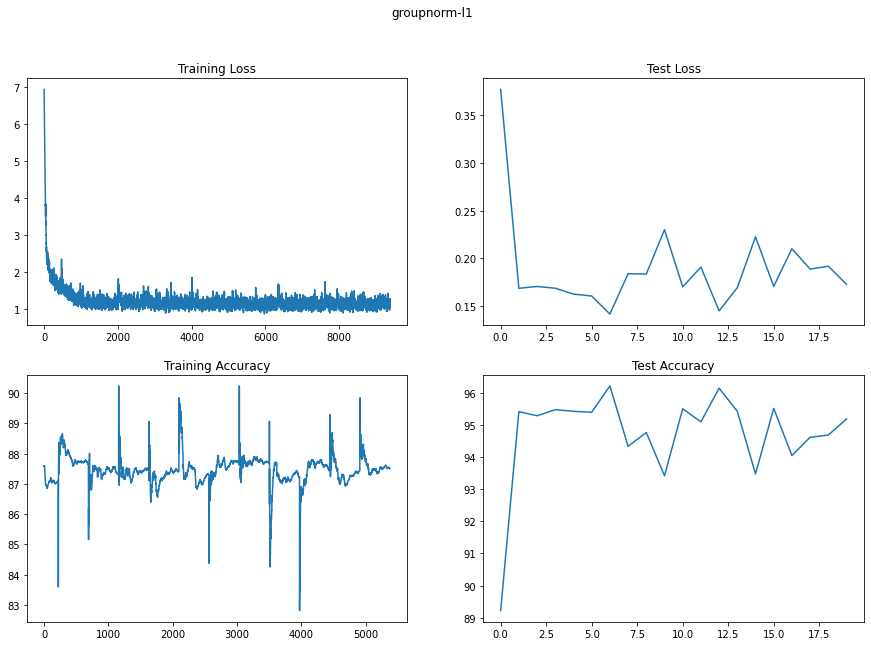

In [ ]:
model, groupnorm_l1_train_losses, groupnorm_l1_test_losses, groupnorm_l1_train_acc, groupnorm_l1_test_acc = train_model("groupnorm-l1", gn=True,l1=True)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


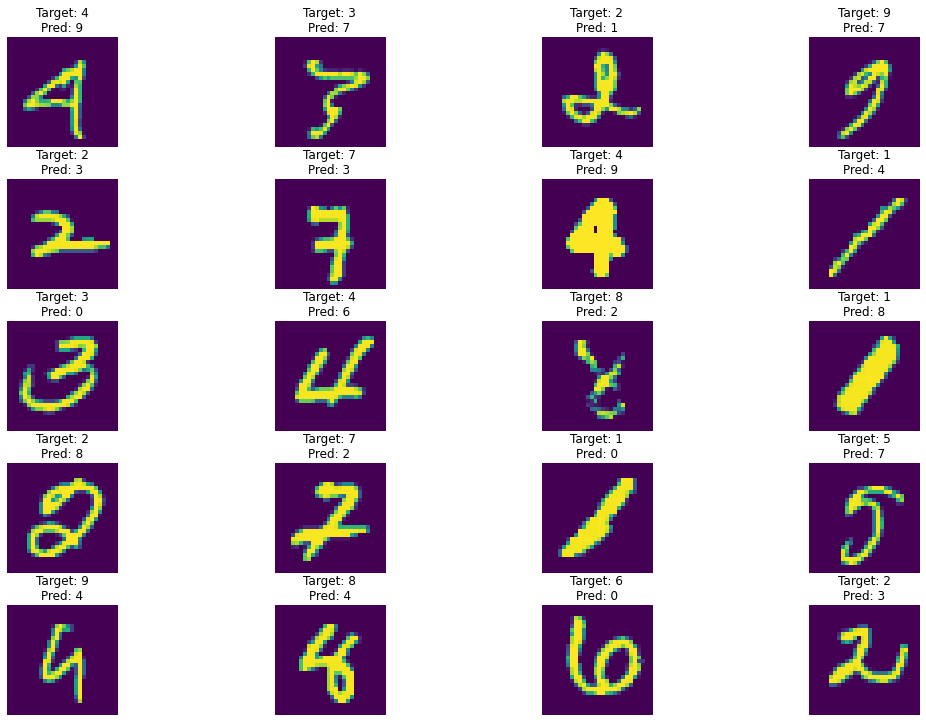

In [ ]:
get_misclassified(model, "groupnorm-L1")
del model

## GroupNorm + L2

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/469 [00:00<?, ?it/s]

CUDA Available? True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
         GroupNorm-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 16, 24, 24]           2,304
              ReLU-5           [-1, 16, 24, 24]               0
         GroupNorm-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
           Dropout-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           2,304
             ReLU-10           [-1, 16, 10, 10]               0
        GroupNorm-11           [-1, 16, 10, 10]              32
        MaxPool2d-12             [-1, 16, 5, 5]               0
          Dropout-13             [-1, 16, 5, 5]               0
           Conv2d-

Loss=0.13743554055690765 Batch_id=468 Accuracy=88.54: 100%|██████████| 469/469 [00:14<00:00, 33.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0794, Accuracy: 9788/10000 (97.88%)

EPOCH: 1


Loss=0.09379392862319946 Batch_id=468 Accuracy=96.30: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9854/10000 (98.54%)

EPOCH: 2


Loss=0.0751609280705452 Batch_id=468 Accuracy=96.76: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9850/10000 (98.50%)

EPOCH: 3


Loss=0.17959880828857422 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0694, Accuracy: 9815/10000 (98.15%)

EPOCH: 4


Loss=0.08987897634506226 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9870/10000 (98.70%)

EPOCH: 5


Loss=0.05182217061519623 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9857/10000 (98.57%)

EPOCH: 6


Loss=0.10281378030776978 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:14<00:00, 32.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9875/10000 (98.75%)

EPOCH: 7


Loss=0.06754887104034424 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9860/10000 (98.60%)

EPOCH: 8


Loss=0.04253946617245674 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9877/10000 (98.77%)

EPOCH: 9


Loss=0.12452741712331772 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9855/10000 (98.55%)

EPOCH: 10


Loss=0.05581974983215332 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0524, Accuracy: 9864/10000 (98.64%)

EPOCH: 11


Loss=0.06265036016702652 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9865/10000 (98.65%)

EPOCH: 12


Loss=0.13876868784427643 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:14<00:00, 32.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9861/10000 (98.61%)

EPOCH: 13


Loss=0.08331524580717087 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9881/10000 (98.81%)

EPOCH: 14


Loss=0.040409620851278305 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9878/10000 (98.78%)

EPOCH: 15


Loss=0.045552682131528854 Batch_id=468 Accuracy=97.51: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9867/10000 (98.67%)

EPOCH: 16


Loss=0.18593959510326385 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9890/10000 (98.90%)

EPOCH: 17


Loss=0.07059315592050552 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9861/10000 (98.61%)

EPOCH: 18


Loss=0.12732799351215363 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9869/10000 (98.69%)

EPOCH: 19


Loss=0.10753365606069565 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]



Test set: Average loss: 0.0457, Accuracy: 9867/10000 (98.67%)



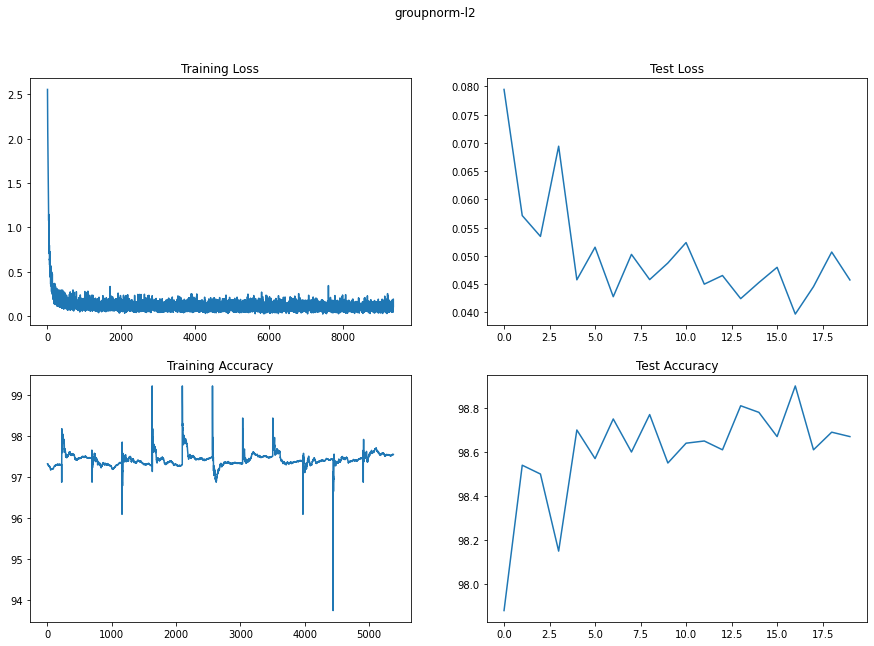

In [ ]:
model, groupnorm_l2_train_losses, groupnorm_l2_test_losses, groupnorm_l2_train_acc, groupnorm_l2_test_acc = train_model("groupnorm-l2", gn=True,l2=True)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


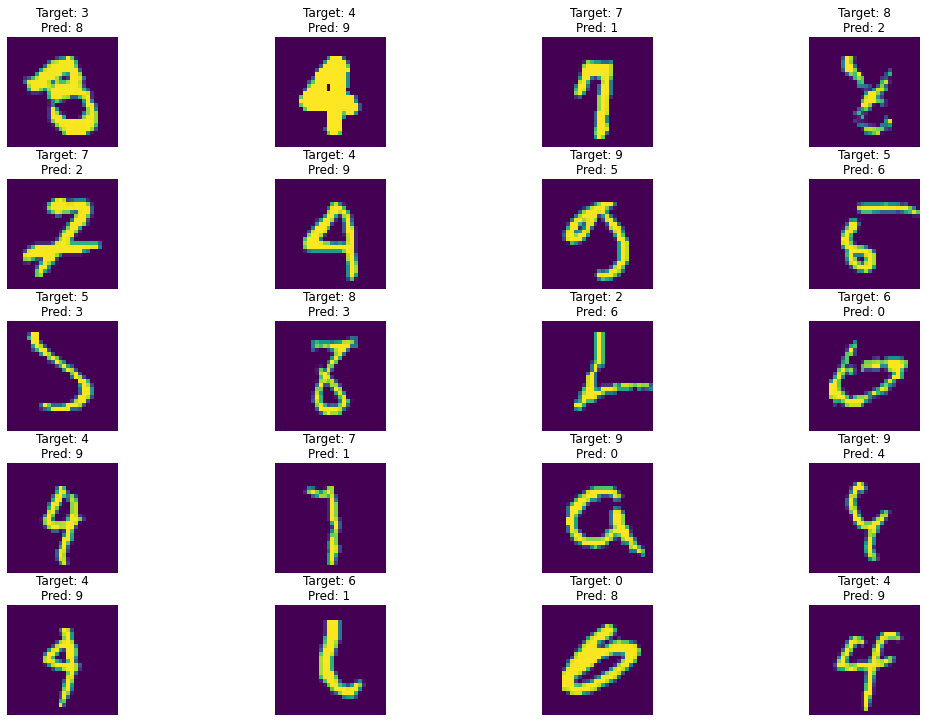

In [ ]:
get_misclassified(model, "groupnorm-L2")
del model

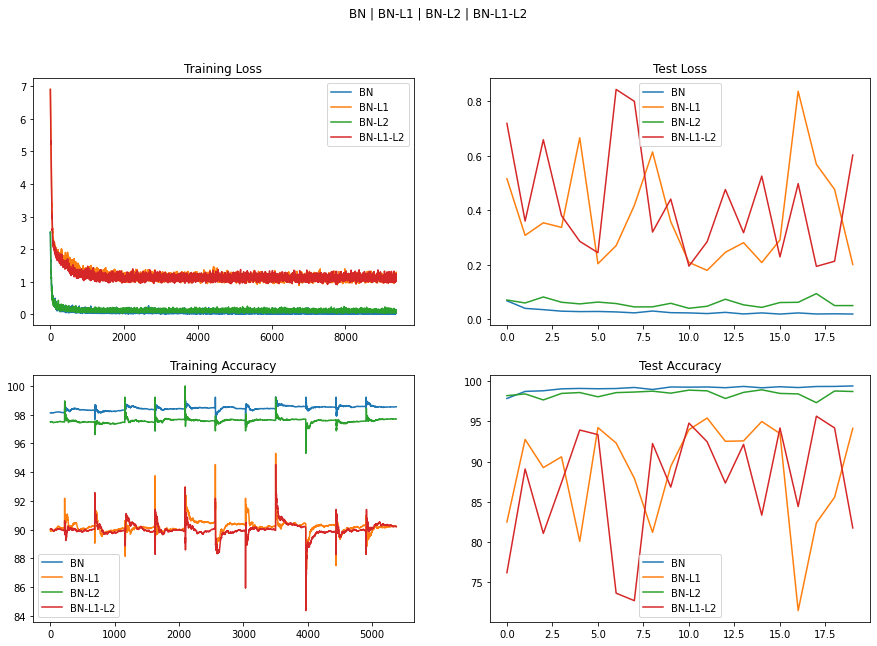

In [ ]:
plot_multi(
    ["BN", "BN-L1", "BN-L2", "BN-L1-L2"],
    [batchnorm_train_losses, batchnorm_l1_train_losses, batchnorm_l2_train_losses, batchnorm_l1_l2_train_losses],
    [batchnorm_train_acc, batchnorm_l1_train_acc, batchnorm_l2_train_acc, batchnorm_l1_l2_train_acc],
    [batchnorm_test_losses, batchnorm_l1_test_losses, batchnorm_l2_test_losses, batchnorm_l1_l2_test_losses],
    [batchnorm_test_acc, batchnorm_l1_test_acc, batchnorm_l2_test_acc, batchnorm_l1_l2_test_acc],
)

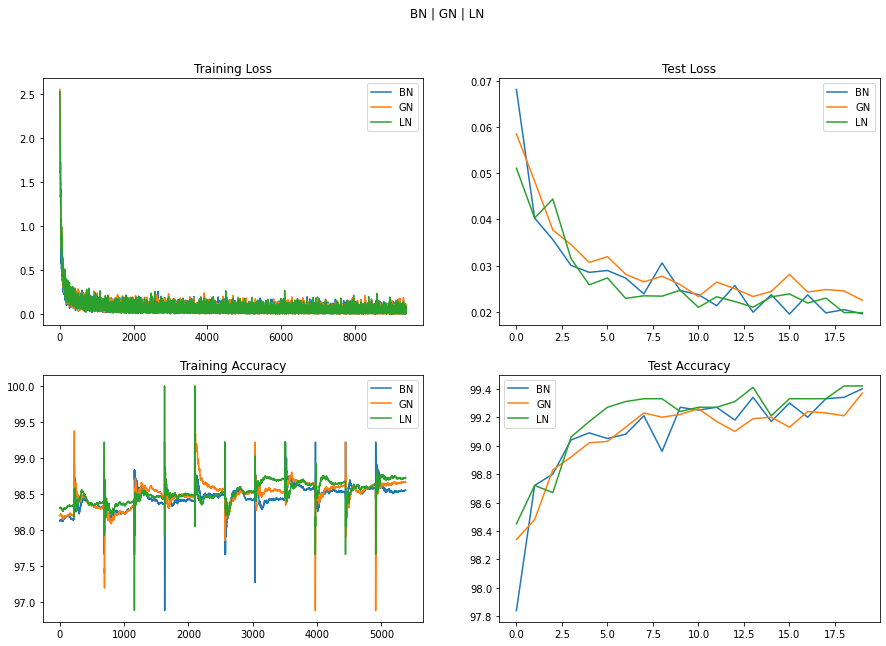

In [ ]:
plot_multi(
    ["BN", "GN", "LN"],
    [batchnorm_train_losses, groupnorm_train_losses, layernorm_train_losses],
    [batchnorm_train_acc, groupnorm_train_acc, layernorm_train_acc],
    [batchnorm_test_losses, groupnorm_test_losses, layernorm_test_losses],
    [batchnorm_test_acc, groupnorm_test_acc, layernorm_test_acc],
)

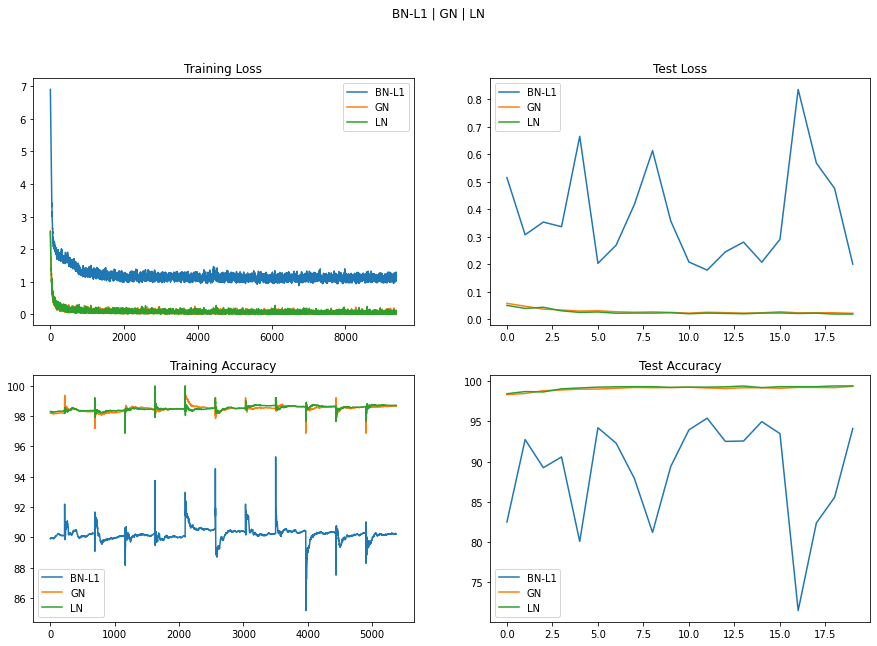

In [ ]:
plot_multi(
    ["BN-L1", "GN", "LN"],
    [batchnorm_l1_train_losses, groupnorm_train_losses, layernorm_train_losses],
    [batchnorm_l1_train_acc, groupnorm_train_acc, layernorm_train_acc],
    [batchnorm_l1_test_losses, groupnorm_test_losses, layernorm_test_losses],
    [batchnorm_l1_test_acc, groupnorm_test_acc, layernorm_test_acc],
)

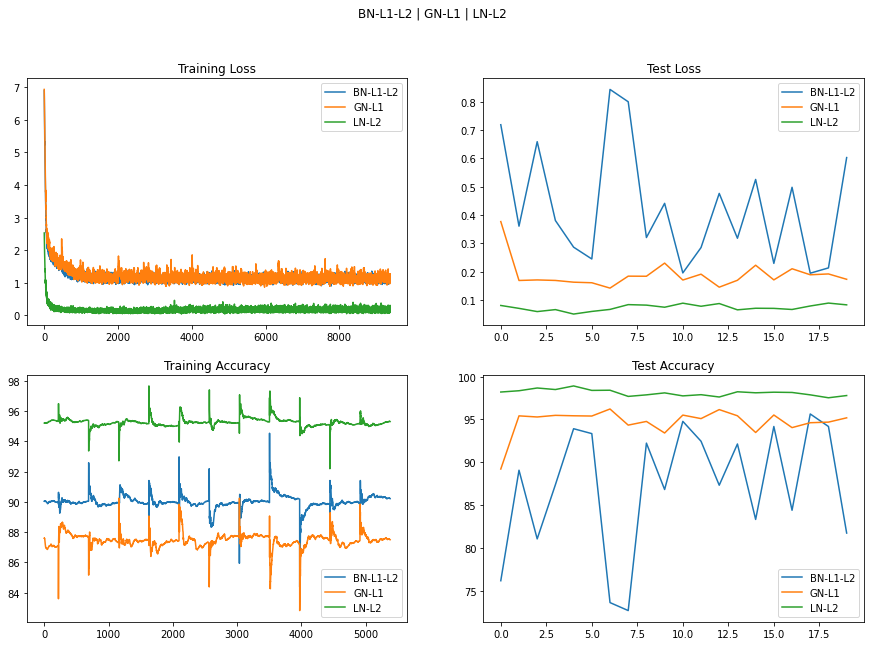

In [ ]:
plot_multi(
    ["BN-L1-L2", "GN-L1", "LN-L2"],
    [batchnorm_l1_l2_train_losses, groupnorm_l1_train_losses, layernorm_l2_train_losses],
    [batchnorm_l1_l2_train_acc, groupnorm_l1_train_acc, layernorm_l2_train_acc],
    [batchnorm_l1_l2_test_losses, groupnorm_l1_test_losses, layernorm_l2_test_losses],
    [batchnorm_l1_l2_test_acc, groupnorm_l1_test_acc, layernorm_l2_test_acc],
)